# پیش‌بینی به کمک مدل VARMA و VAR و مقایسه با ARIMA
(برای دو سهم بازار بورس تهران)

کد به سه بخش تقسیم می‌شود:

- مدل VARMA
- مدل VAR
- مدل ARIMA

مقایسه سه مدل بالا به کمک سنجهٔ `r2_score` انجام خواهد شد.

![alt text](r2.png)

### آماده‌سازی

با ران کردن کد، متوجه شدم که خروجی دارای هشدار‌های زیادی است که پس از بررسی، تصمیم گرفتم تا مانع چاپ هشدارها در خروجی شوم تا 
خروجی تمیزتر باشد.

In [36]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

ایمپورت بستهٔ‌های یاهوفاننس و `pytse_client` برای دریافت دادهٔ مربوط به قیمت سهام:

In [4]:
import yfinance as yf       # https://pypi.org/project/yfinance/
import pytse_client as tse # https://pypi.org/project/pytse-client/
import pandas as pd

## دریافت اطلاعات

دو سهم وبصادر و وتجارت برای این تمرین انتخاب شده‌اند:

In [23]:
tickers_tse = ['وبصادر', 'وتجارت']
prices_dict = tse.download(symbols=tickers_tse, adjust=True)
prices_dict_reform = {(outerKey, innerKey):
                             values for outerKey, innerDict 
                             in prices_dict.items() for innerKey, values 
                             in innerDict.iteritems()}
data_tse = pd.DataFrame(prices_dict_reform)
d = {'وبصادر': 'Saderat', 'وتجارت' : 'Tejarat'}
data_tse = data_tse.rename(columns=d, level=0)
df_tse = data_tse.dropna()[-3*254:]

df_tse.columns = [' '.join(col) for col in df_tse.columns]
df_tse = df_tse[['Saderat adjClose', 'Tejarat adjClose']]
df_tse.columns = ['saderat', 'tejarat']

## ایمپورت بسته‌ها و توابع موردنیاز

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## آشنایی با داده

نمودار وبصادر و وتجارت را با هم رسم می‌کنیم.

<AxesSubplot:>

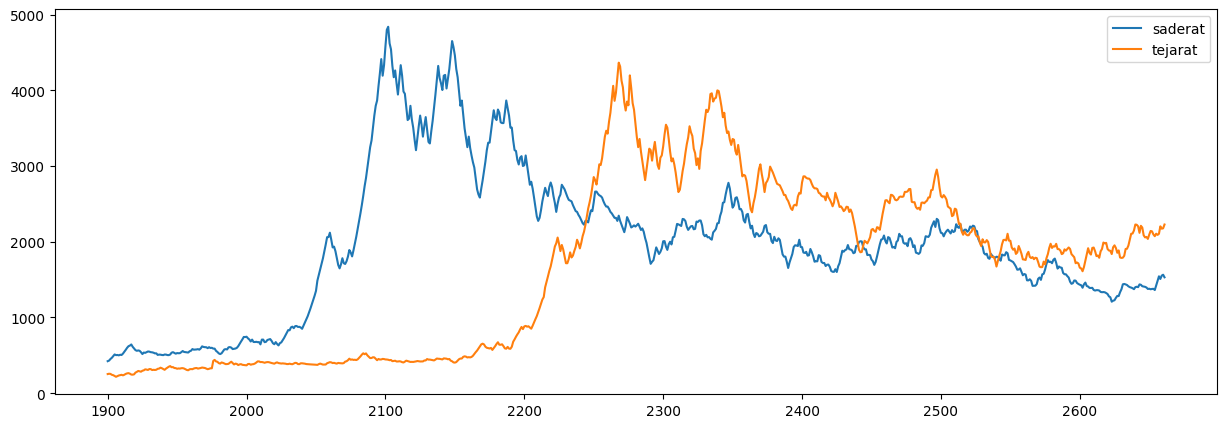

In [25]:
df_tse[['saderat', 'tejarat']].plot(figsize=(15, 5))

شرط کارایی مدل‌های این تمرین، مانایی سری‌های زمانی است. از آن‌جایی که سری زمانی قیمت‌ها مانا نیست، سراغ سری زمانی بازده‌ها می‌رویم.

سری زمانی بازده‌ها را به صورت زیر می‌سازیم:

In [26]:
df_tse['saderat_ret'] = np.log(df_tse['saderat']).diff()
df_tse['tejarat_ret'] = np.log(df_tse['tejarat']).diff()

cols = ['saderat_ret', 'tejarat_ret']
df_tse_returns = df_tse.iloc[1:][cols].copy()

برای تست مدل‌ها در داده خارج از نمونه، دیتاست را به دو بخش آموزش و آزمون تقسیم می‌کنیم:

In [27]:
test_count = 24
train = df_tse_returns[:-test_count].copy()
test = df_tse_returns[-test_count:].copy()

train_idx = df_tse_returns.index <= train.index[-1]
test_idx = ~train_idx

آز آنجاییکه تعداد پارامترهای مدل‌های VARMA زیاد است، بهینه‌سازی این پارامترها به کمک scale کردن دیتا، بهتر صورت می‌گیرد؛ بنابراین به کمک `StandardScaler` دیتاست را scale می‌کنیم:

In [28]:
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

df_tse_returns.loc[train_idx, :] = train
df_tse_returns.loc[test_idx, :] = test

برای یافتن کاندید‌های مقادیر p و q توابع acf و pacf سری بازده‌ها را رسم می‌کنیم.

با توجه به این نمودارها و آزمایش و خطا، مقدار p برابر 20 و مقدار q برابر 3 انتخاب شدند:

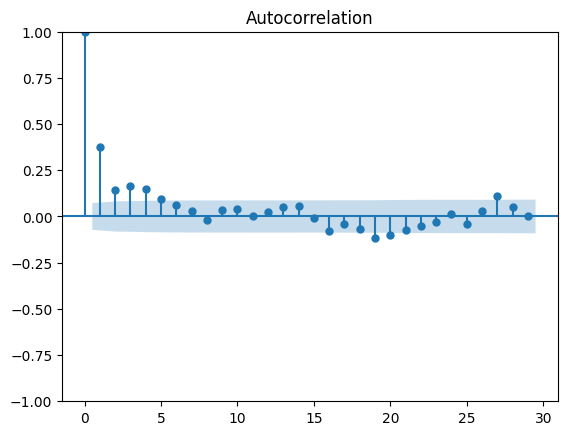

In [29]:
plot_acf(train['saderat_ret']);

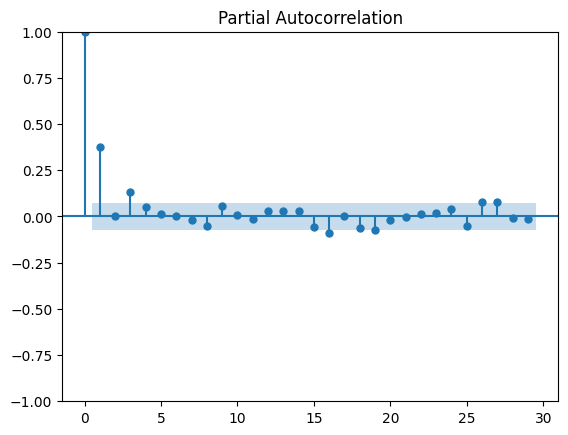

In [30]:
plot_pacf(train['saderat_ret']);

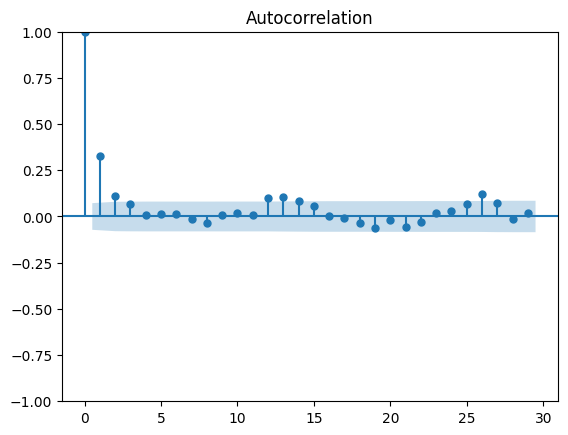

In [31]:
plot_acf(train['tejarat_ret']);

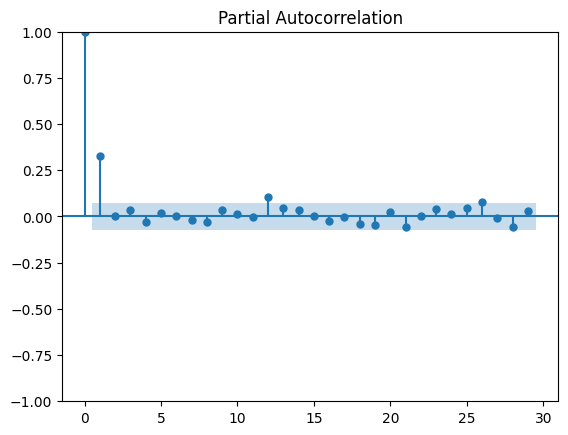

In [32]:
plot_pacf(train['tejarat_ret']);

پیش از شروع مدل‌سازی‌ها، از مانایی سری زمانی بازده‌ها اطمینان حاصل می‌کنیم. نتیجه آن‌که هر دو سری زمانی، در بازهٔ اطمینان ۹۹ درصد مانا هستند:

In [33]:
(adfuller(train['saderat_ret'])[1] < 0.01,
adfuller(train['tejarat_ret'])[1] < 0.01)

(True, True)

## مدل VARMAX

به کمک کلاس VARMAX در بستهٔ `statsmodels` مدل‌سازی را با داده آموزش انجام می‌دهیم: 

In [34]:
p, q = 20, 3

t0 = datetime.now()
model = VARMAX(train, order=(p, q));
res = model.fit(maxiter=20);
print('Duration:', datetime.now() - t0)

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           97     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63713D+00    |proj g|=  5.67572D-02


 This problem is unconstrained.



At iterate    5    f=  2.63439D+00    |proj g|=  2.66419D-03

At iterate   10    f=  2.63298D+00    |proj g|=  6.56215D-03

At iterate   15    f=  2.63250D+00    |proj g|=  1.90201D-03

At iterate   20    f=  2.63238D+00    |proj g|=  2.05868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   97     20     25      1     0     0   2.059D-03   2.632D+00
  F =   2.6323839329356407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:01:42.353760


مدل فیت‌شده را برای به دست آوردن مقادیر پیش‌بینی داده آزمایش به کار می‌بریم:

In [37]:
fcast = res.get_forecast(test_count)

نمودار بازده سهام وبصادر را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

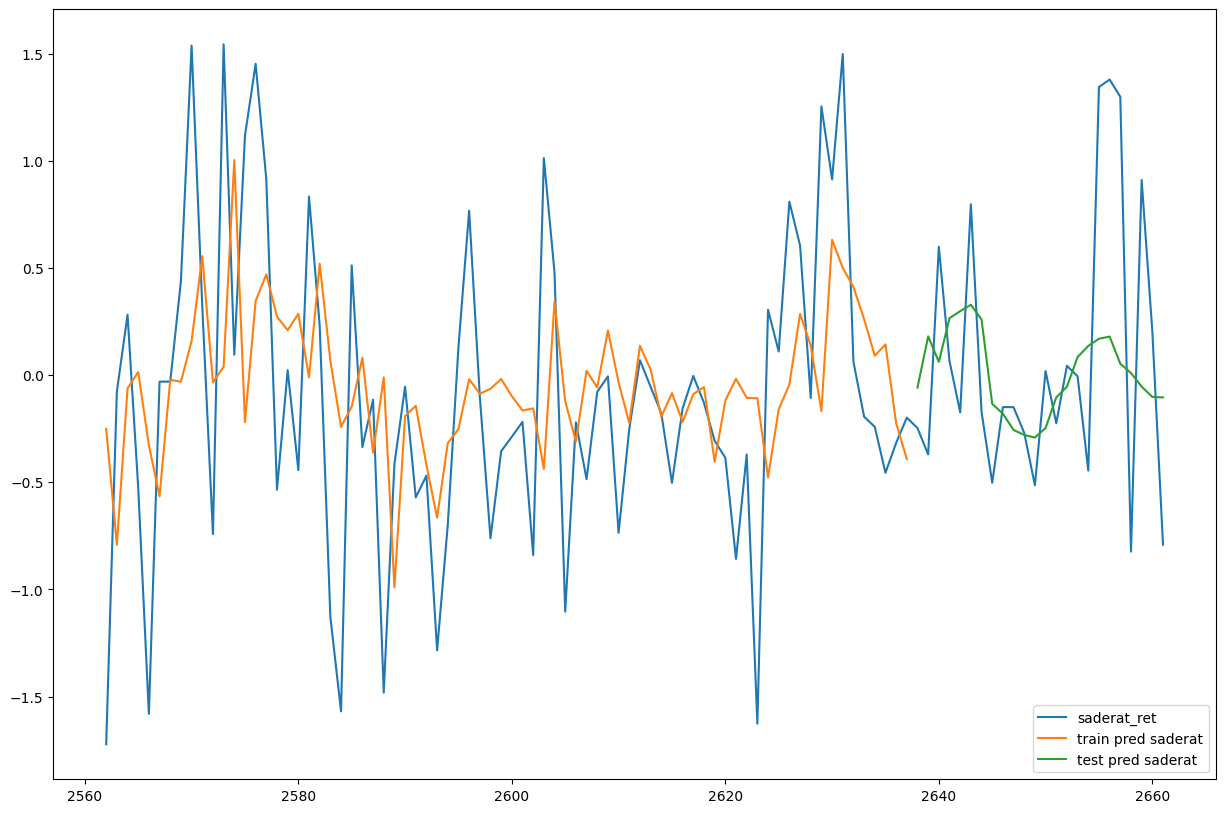

In [38]:
df_tse_returns.loc[train_idx, 'train pred saderat'] = res.fittedvalues['saderat_ret']
df_tse_returns.loc[test_idx, 'test pred saderat'] = np.nan
df_tse_returns.iloc[-test_count:]['test pred saderat'] = fcast.predicted_mean['saderat_ret'].values

plot_cols = ['saderat_ret', 'train pred saderat', 'test pred saderat']
df_tse_returns.iloc[-100:][plot_cols].plot(figsize=(15, 10));

نمودار بازده سهام وتجارت را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

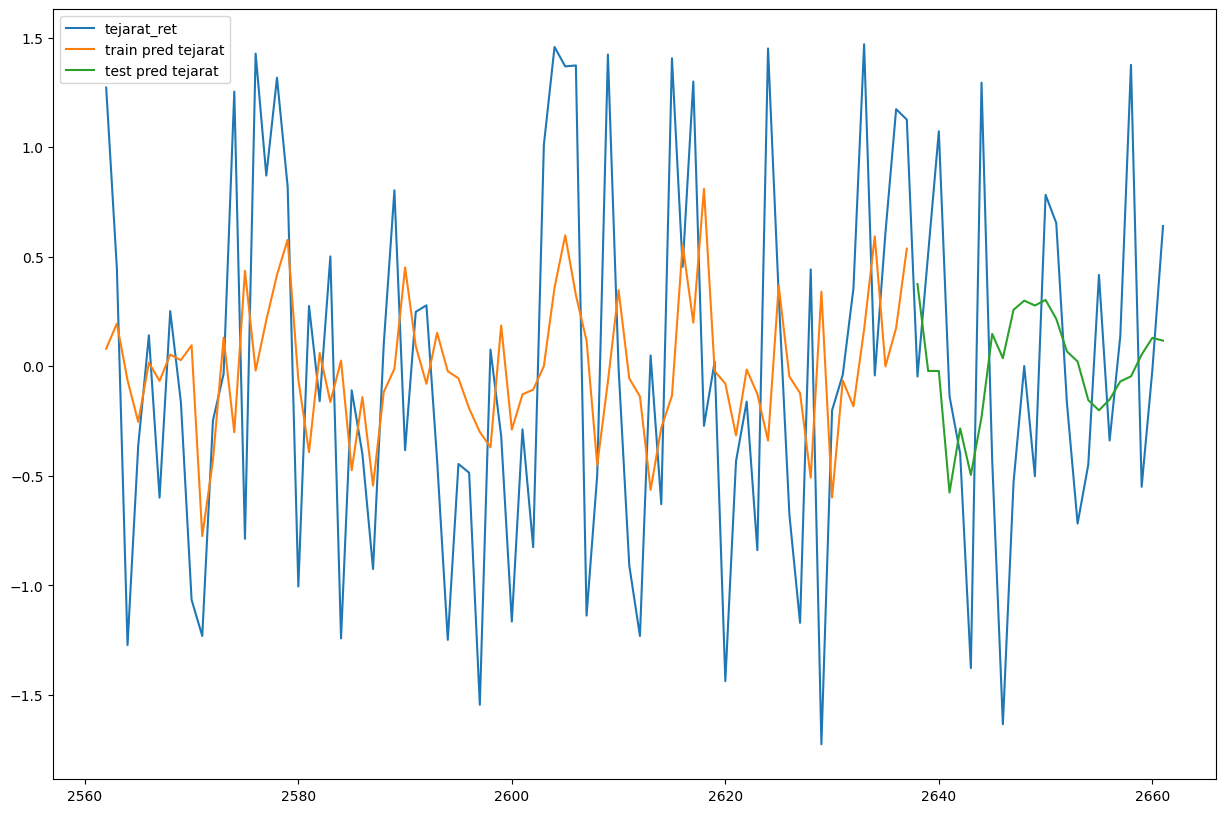

In [39]:
df_tse_returns.loc[train_idx, 'train pred tejarat'] = res.fittedvalues['tejarat_ret']
df_tse_returns.loc[test_idx, 'test pred tejarat'] = np.nan
df_tse_returns.iloc[-test_count:]['test pred tejarat'] = fcast.predicted_mean['tejarat_ret'].values

plot_cols = ['tejarat_ret', 'train pred tejarat', 'test pred tejarat']
df_tse_returns.iloc[-100:][plot_cols].plot(figsize=(15, 10));

برای ارزیابی مدل، مقدار سنجهٔ `R^2` را برای داده آموزش و آزمایش محاسبه می‌کنیم.

- هر دو سری زمانی در دادهٔ آموزش، عملکرد قابل قبولی داشتند.
- در دادهٔ آزمایش، مدل پیش‌بینی قابل‌قبولی برای سهم وبصادر داشته است. اما برای سهام وتجارت، مقدار `R^2` منفی است بنابراین مدل از عدد ثابت میانیگن دادهٔ واقعی آزمون بدتر پیش‌بینی کرده است و قابل قبول نیست؛ هر چند که پیش‌بینی خود میانیگن کاری دشوار است.

In [40]:
for col in cols:
    print()
    print(col, '=>')
    y_true = df_tse_returns.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R^2:", r2_score(y_true, y_pred))

    y_true = df_tse_returns.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R^2:", r2_score(y_true, y_pred))


saderat_ret =>
Train R^2: 0.19884617448105257
Test R^2: 0.1127129289461456

tejarat_ret =>
Train R^2: 0.1723893647367437
Test R^2: -0.03215973247266124


## مدل VAR

به کمک کلاس VAR در بستهٔ `statsmodel` مدل‌سازی را بر روی دادهٔ آموزش انجام می‌دهیم و پیش‌بینی‌ها را برای دادهٔ آزمون محاسبه می‌کنیم:

In [41]:
model = VAR(train)
results = model.fit(maxlags=20, ic='aic')
lag_order = results.k_ar

prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, test_count)

نمودار بازده سهام وبصادر را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

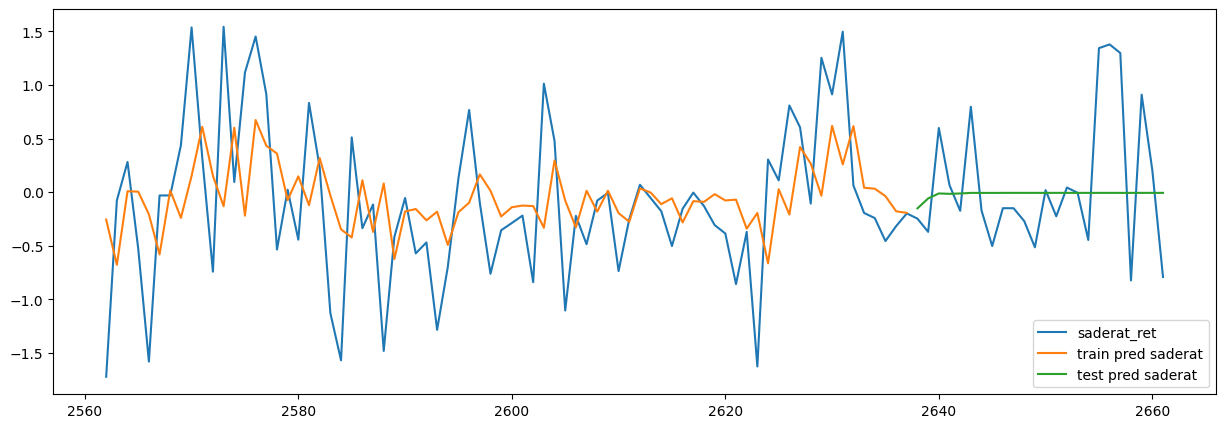

In [42]:
df_tse_returns.loc[train_idx, 'train pred saderat'] = results.fittedvalues['saderat_ret']
df_tse_returns.loc[test_idx, 'test pred saderat'] = fcast[:, 0]
plot_cols = ['saderat_ret', 'train pred saderat', 'test pred saderat']
df_tse_returns[-100:][plot_cols].plot(figsize=(15, 5));

نمودار بازده سهام وتجارت را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

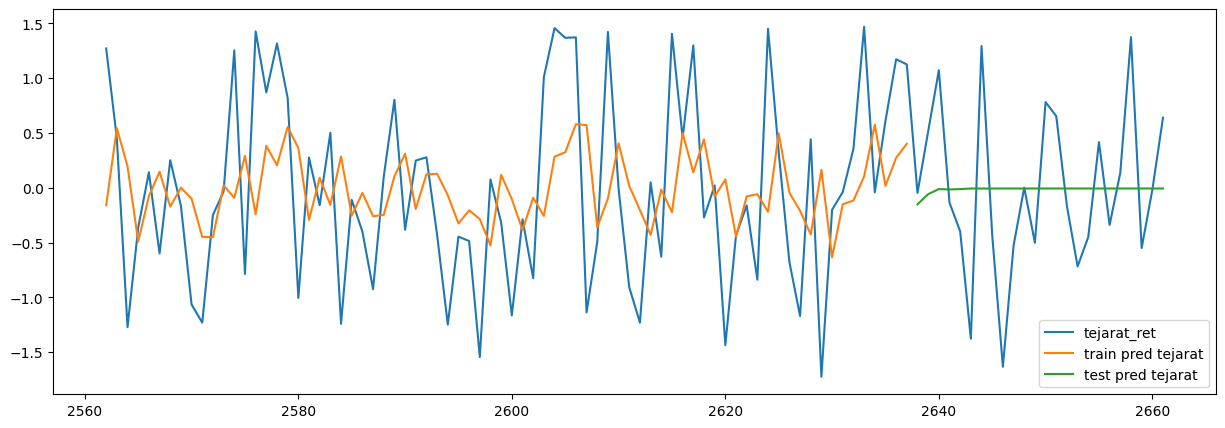

In [43]:
df_tse_returns.loc[train_idx, 'train pred tejarat'] = results.fittedvalues['tejarat_ret']
df_tse_returns.loc[test_idx, 'test pred tejarat'] = fcast[:, 0]
plot_cols = ['tejarat_ret', 'train pred tejarat', 'test pred tejarat']
df_tse_returns[-100:][plot_cols].plot(figsize=(15, 5));

برای ازریابی مدل، سنجهٔ `R^2` را برای دادهٔ آموزش و آزمایش سهام وبصادر محاسبه می‌کنیم:

- در دادهٔ آزمایش، عملکرد مدل همانند مدل VARMA قابل قبول است.
- اما در دادهٔ آزمایش، عملکرد خوبی نداشته است.

In [44]:
y_pred = df_tse_returns.loc[train_idx, 'train pred saderat']
y_true = df_tse_returns.loc[train_idx, 'saderat_ret']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("saderat train R^2:", r2_score(y_true, y_pred))

y_pred = df_tse_returns.loc[test_idx, 'test pred saderat']
y_true = df_tse_returns.loc[test_idx, 'saderat_ret']
print('saderat test r^2:', r2_score(y_true, y_pred))

saderat train R^2: 0.15713204088884714
saderat test r^2: -0.008824844123367148


برای ازریابی مدل، سنجهٔ `R^2` را برای دادهٔ آموزش و آزمایش سهام وتجارت محاسبه می‌کنیم:

- در دادهٔ آزمایش، عملکرد مدل همانند مدل VARMA قابل قبول است.
- اما در دادهٔ آزمایش، عملکرد خوبی نداشته است.

In [46]:
y_pred = df_tse_returns.loc[train_idx, 'train pred tejarat']
y_true = df_tse_returns.loc[train_idx, 'tejarat_ret']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("tejarat train R^2:", r2_score(y_true, y_pred))

y_pred = df_tse_returns.loc[test_idx, 'test pred tejarat']
y_true = df_tse_returns.loc[test_idx, 'tejarat_ret']
print('tejarat test r^2:', r2_score(y_true, y_pred))

tejarat train R^2: 0.1167354007395337
tejarat test r^2: -0.0055386776563217666


# مدل ARIMA

مدل آریما را به عنوان Baseline برای مقایسه دو مدل پیشین در نظر می‌گیریم:

مرتبه‌های p و q را همانند مدل VARMAX انتخاب می‌کنیم. 

پس از مدل‌سازی، سنجهٔ `R^2` را برای داده آموزش و آزمایش محاسبه می‌کنیم.

- هر دو سهام در دادهٔ آموزش نتیجهٔ قابل قبولی دارند.
- در دادهٔ آزمایش، مدل پیش‌بینی قابل‌قبولی برای سهم وبصادر داشته است. اما برای سهام وتجارت، مقدار `R^2` منفی است بنابراین مدل از عدد ثابت میانیگن دادهٔ واقعی آزمون بدتر پیش‌بینی کرده است و قابل قبول نیست؛ هر چند که پیش‌بینی خود میانیگن کاری دشوار است.

In [48]:
for col in cols:
    model = ARIMA(train[col], order=(p, 0, q))
    res = model.fit()
    fcast = res.get_forecast(test_count)
    y_train = df_tse_returns.loc[train_idx, col]
    y_test = df_tse_returns.loc[test_idx, col]
    print(f"{col} train R^2:", r2_score(y_train, res.fittedvalues))
    print(f"{col} test R^2:", r2_score(y_test, fcast.predicted_mean))
    print()

saderat_ret train R^2: 0.1845267278381355
saderat_ret test R^2: 0.13098315202006916

tejarat_ret train R^2: 0.13368750091591752
tejarat_ret test R^2: -0.053693216351549555

